<center><img src="https://pure.ups.edu.ec/skin/headerImage/" width="300" height="300"></center>

<h1><center>Universidad Politecnica Salesiana</center></h1>
<h2><center>Simulacion Simpy Vacunas</center></h2>


<b>Nombre: </b> Javier Vazquez

<b>Materia: </b> Simulacion


In [57]:
import simpy
import random
import datetime as dt
from datetime import datetime

### Variables de Interes

En este caso hemos decidido utilizar las siguientes variables de interes
* <b>Mesas Vacunacion: </b> seran las mesas con las que cuenta el recinto para realizar el proceso de vacunacion
* <b>Tiempo simulacion: </b>  tiempo que se tardara la simulacion 
* <b>Intervalo Llegada: </b> intervalo en la que se genera una nueva persona dentro de la simulacion 
* <b>Tiempo Vacunacion: </b> tiempo minimo que tarda en vacunar a una persona
* <b>Tiempo espera sintomas: </b> tiempo de que espera una persona despues de ser vacunado para verificar que no tenga problemas de salud
* <b>Tiempo certificado: </b>  tiempo minimo en entregar el certificado de vacunacion a la persona'
* <b>Cola: </b> numero de personas generadas a que formen cola para recibir la vacuna 
* <b>Porcentaje proceso ecuador: </b> del total de la poblacion que existe en ecuador, porcentaje que se prevee asista al proceso de vacunacion 
* <b>Porcentaje no vacunar: </b>  porcentaje de las personas que acuden al proceso no pueden vacunarse por algun problema de salud 
* <b>Estado personas: </b>  guardar el estado de todas las personas(no proceso, cola, espera, vacunado, espera, carnet, no califica)
* <b>Tiempos espera final: </b>  tiempo de espera cada persona en la cola hasta ser atendido por una mesa 
* <b>Tiempos vacunacion final: </b> tiempo en vacunarse cada persona
* <b>Mesas libres vacunacion: </b> comprobar si una mesa se encuentra libre para aceptar nueva persona se vacune

In [58]:
MESAS_VACUNACION=5 
TIEMPO_SIMULACION=500
INTERVALO_LLEGADA=5
TIEMPO_VACUNACION=5
TIEMPO_ESPERAR_SINTOMAS=20
TIEMPO_CERTIFICADO=2
COLA=10
PORCENTAJE_PROCESO_ECUADOR=80 
PORCENTAJE_NO_VACUNAR=10
estado_personas={} 
tiempos_espera={} 
tiempo_vacunacion_final={} 
tiempo_espera_final={}
MESAS_LIBRES_VACUNACION={}

### Variables Auxiliares
* personas vacunacion
* personas espera
* personas carnet

In [59]:
personas_vacunacion={}
personas_espera={}
personas_carnet={}
SEGUNDA_DOSIS= datetime.now().strftime('%d/%m/%Y')
for i in range(MESAS_VACUNACION):
    MESAS_LIBRES_VACUNACION[i]='Libre'

### Desarrollo de clases

Para esta simulacion unicamente se cuenta con la clase:
* <b>Vacunacion </b> En la cual contiene los metodos respectivos a cada uno de la fases de la vacunacion como proceso vacunaciopn, comprobar si una mesa se encuentra libre, el proceso de esperar a posibles problemas de salud despues de recibir la vacuna y la entrega del carnet. <br>
Cuando una persona pasa por cada uno de esos procesos automaticamente se van cambiando los estados en los cuales se encuentra la persona dentro del proceso de vacunacion 


In [60]:
class Vacunacion(object):
    
    def __init__(self, environment, mesas_vacunacion):
        self.env= environment
        self.mesas_vacunacion = simpy.Resource(environment, mesas_vacunacion)
        
    def proceso_vacunacion(self, nombre, tiempo, idMesa):
        yield self.env.timeout(random.randint(tiempo, tiempo+5))
        estado_personas[nombre]='Vacunado'
        MESAS_LIBRES_VACUNACION[idMesa]='Libre'
        
    def mesas_libres_vacunacion(self, num_mesa):
        if MESAS_LIBRES_VACUNACION.get(num_mesa) =='Libre':
            return True
        else:
            return False
        
    def proceso_esperar(self,nombre, tiempo):
        yield self.env.timeout(tiempo)
        estado_personas[nombre]='Espera_sintomas'
    
    def entrega_carnet(self, nombre, tiempo):
        yield self.env.timeout(tiempo)
        estado_personas[nombre]='Carnet'
        
    def salir_recinto(self):
        yield self.env.timeout(random.randint(1,5))

### Desarrollo logica de la simulacion 

In [61]:


def llegada_personas(env, nombre, vacunacion, tiempo_vacunacion, tiempo_espera, tiempo_certificado):
    
    if random.randint(1,100)>=(100-PORCENTAJE_PROCESO_ECUADOR):
        print('---> Genera [%s] a la cola hora %.2f.'%(nombre,env.now))
        if random.randint(1,100)<=PORCENTAJE_NO_VACUNAR:
            print('❌'*3,'[%s] acude al proceso pero no puede vacunarse  '%(nombre),'❌'*3)
            estado_personas[nombre]='No califica'
        else:
            estado_personas[nombre]='Cola'
            llegada=env.now
            tiempos_espera[nombre]=env.now
            with vacunacion.mesas_vacunacion.request() as mesas:
                yield mesas
                lista_cola=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Cola']
                for i in range(MESAS_VACUNACION):
                    if len(lista_cola)>0:
                        persona_cola=lista_cola[0]
                        if vacunacion.mesas_libres_vacunacion(i):
                            if not persona_cola in personas_vacunacion:
                                MESAS_LIBRES_VACUNACION[i]='Ocupada'
                                personas_vacunacion[persona_cola]=i
                                inicio_vacunacion=env.now
                                print('💉 La: [%s] entra a vacunarse al hora %.2f MESA %s luego de esperar  %s minutos '%(persona_cola,env.now, i+1, env.now-tiempos_espera[persona_cola]))
                                tiempo_espera_final[persona_cola]=env.now-tiempos_espera[persona_cola]
                                yield env.process(vacunacion.proceso_vacunacion(persona_cola, tiempo_vacunacion,i))
                                print('Sale de vacunarse [%s] a la hora %.2f libre MESA %s se demoro %s minutos'%(persona_cola, env.now, i+1, env.now-inicio_vacunacion))
                                tiempo_vacunacion_final[persona_cola]=env.now-inicio_vacunacion
                        lista_cola.remove(persona_cola)
                lista_vacuna=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Vacunado']
                for i in lista_vacuna:
                    if not i in personas_espera:
                        print('⌛ La: [%s] entra a la sala de espera al hora %.2f '%(i, env.now))
                        personas_espera[i]='espera'
                        yield env.process(vacunacion.proceso_esperar(i,tiempo_espera))
                        #print(' **** La: [%s] sale de sala de espera al hora %.2f '%(i, env.now))
                lista_espera=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Espera_sintomas']
                for i in lista_espera:
                    if not i in personas_carnet:
                        prox_cita = datetime.strftime(datetime.strptime(SEGUNDA_DOSIS, '%d/%m/%Y')+dt.timedelta(days=21), '%d/%m/%Y')
                        personas_carnet[i]='carnet'
                        yield env.process(vacunacion.entrega_carnet(i,tiempo_certificado))
                        print('📝 La: [%s] recibe su carnet al hora %.2f con fecha para segunda dosis %s'%(i, env.now, prox_cita))
                        
                        yield env.process(vacunacion.salir_recinto())
                        print('<<--- La: [%s] abandona las instalaciones al hora %.2f '%(i, env.now))
        
    else:
        print('---> Genera [%s] hora %.2f. no realiza proceso ☠️'%(nombre,env.now))
        estado_personas[nombre]='No proceso'
    

### Ejecutar Simulacion

In [62]:
def ejecutar_simulacion(env, mesas_vacunacion, intervalo_llegada, tiempo_vacunacion, tiempo_espera,tiempo_certificado):
    vacunacion = Vacunacion(env, mesas_vacunacion)
    i=0
    for j in range(COLA):
        env.process(llegada_personas(env,'Persona-%d'%(i+1), vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado))
        i+=1
    while True:
        i+=1
        yield env.timeout(random.randint(intervalo_llegada-2, intervalo_llegada+2))
        env.process(llegada_personas(env,'Persona-%d'%(i), vacunacion,  tiempo_vacunacion, tiempo_espera, tiempo_certificado))
        
random.seed(77)
env= simpy.Environment()
env.process(ejecutar_simulacion(env, MESAS_VACUNACION,INTERVALO_LLEGADA, TIEMPO_VACUNACION, TIEMPO_ESPERAR_SINTOMAS, TIEMPO_CERTIFICADO))
env.run(until=TIEMPO_SIMULACION)

---> Genera [Persona-1] a la cola hora 0.00.
---> Genera [Persona-2] a la cola hora 0.00.
---> Genera [Persona-3] hora 0.00. no realiza proceso ☠️
---> Genera [Persona-4] a la cola hora 0.00.
---> Genera [Persona-5] a la cola hora 0.00.
---> Genera [Persona-6] a la cola hora 0.00.
---> Genera [Persona-7] a la cola hora 0.00.
---> Genera [Persona-8] a la cola hora 0.00.
---> Genera [Persona-9] hora 0.00. no realiza proceso ☠️
---> Genera [Persona-10] a la cola hora 0.00.
❌❌❌ [Persona-10] acude al proceso pero no puede vacunarse   ❌❌❌
💉 La: [Persona-1] entra a vacunarse al hora 0.00 MESA 1 luego de esperar  0 minutos 
💉 La: [Persona-2] entra a vacunarse al hora 0.00 MESA 2 luego de esperar  0 minutos 
💉 La: [Persona-4] entra a vacunarse al hora 0.00 MESA 3 luego de esperar  0 minutos 
💉 La: [Persona-5] entra a vacunarse al hora 0.00 MESA 4 luego de esperar  0 minutos 
💉 La: [Persona-6] entra a vacunarse al hora 0.00 MESA 5 luego de esperar  0 minutos 
---> Genera [Persona-11] a la cola h

### Resultados 

In [63]:
vacunados=0
proceso=0
no_atendidos=0
no_proceso=0
cola=0
for key in estado_personas:
    if estado_personas[key]=='Carnet': vacunados+=1
    if estado_personas[key]=='No proceso': no_proceso+=1
    if estado_personas[key]=='No califica': no_atendidos+=1
    if estado_personas[key]=='Cola': cola+=1
    if estado_personas[key]=='Carnet' or estado_personas[key]=='No califica' or estado_personas[key]=='Cola':  proceso+=1
print('-'*70,'\n* Total personas Generadas: ', len(estado_personas))
print('* Personas que asistieron al proceso: ', proceso)
print('* Personas que no asistieron al proceso: ', no_proceso)
print('* Personas que no pudieron vacunarse: ', no_atendidos)
print('* Personas que se vacunaron: ', vacunados)
print('* Personas que aun se encuentran en cola: ', cola)
print('* Tiempo promedio espera en la cola a ser atendido: ',sum(list(tiempo_espera_final.values()))/len(tiempo_espera_final),'\n','-'*70)

---------------------------------------------------------------------- 
* Total personas Generadas:  108
* Personas que asistieron al proceso:  84
* Personas que no asistieron al proceso:  20
* Personas que no pudieron vacunarse:  9
* Personas que se vacunaron:  70
* Personas que aun se encuentran en cola:  5
* Tiempo promedio espera en la cola a ser atendido:  8.631578947368421 
 ----------------------------------------------------------------------


### Grafico tiempo espera en la cola

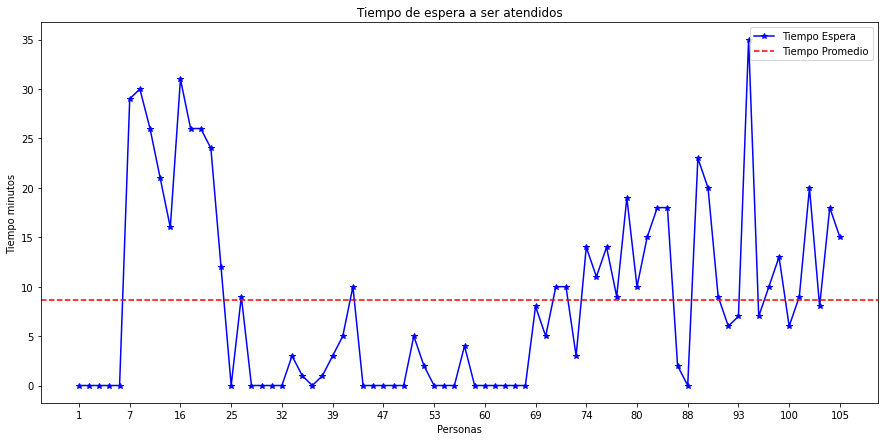

In [64]:
import matplotlib.pyplot as plt

promedio={}
for i in list(tiempo_espera_final.keys()):
    #print(i.split('-'))
    promedio[i.split('-')[1]]=tiempo_espera_final[i]


plt.figure(figsize = (15,7))
plt.plot(list(promedio.keys()),list(promedio.values()),'*-b')
plt.xticks(list(promedio.keys())[::5])
plt.axhline(y=sum(list(tiempo_espera_final.values()))/len(tiempo_espera_final), xmin=0.0, xmax=1,color='red',linestyle="--")

plt.title('Tiempo de espera a ser atendidos')
plt.xlabel('Personas')
plt.ylabel('Tiempo minutos')
plt.legend(['Tiempo Espera','Tiempo Promedio'])

### Grafico tiempo vacunacion de las personas

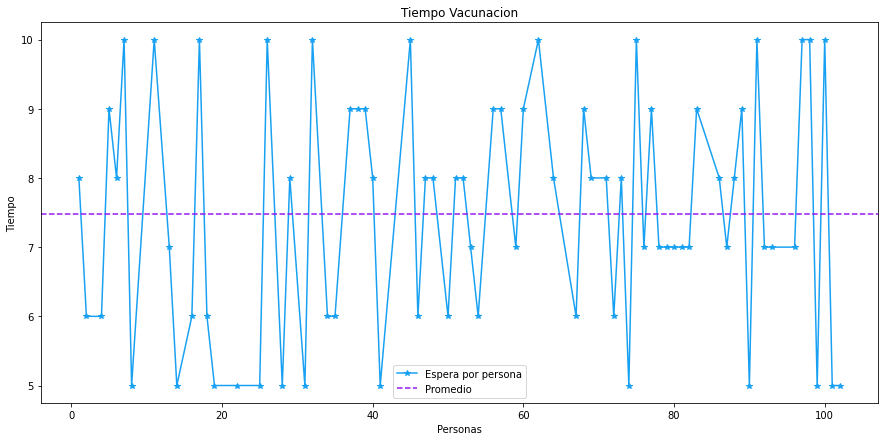

In [65]:
promedio_vacunacion={}
for i in list(tiempo_vacunacion_final.keys()):
    #print(i.split('-'))
    promedio_vacunacion[int(i.split('-')[1])]=tiempo_vacunacion_final[i]
promedio_vacunacion=dict(sorted(promedio_vacunacion.items()))

plt.figure(figsize = (15,7))
plt.plot(promedio_vacunacion.keys(), promedio_vacunacion.values(),'*-', color='#18A1F2')
plt.axhline(y=sum(list(tiempo_vacunacion_final.values()))/len(tiempo_vacunacion_final), xmin=0.0, xmax=1,color='#9318F2',linestyle="--")
plt.title('Tiempo Vacunacion')
plt.xlabel('Personas')
plt.ylabel('Tiempo')
plt.legend(['Espera por persona', 'Promedio'])

### Grafico personas total generadas

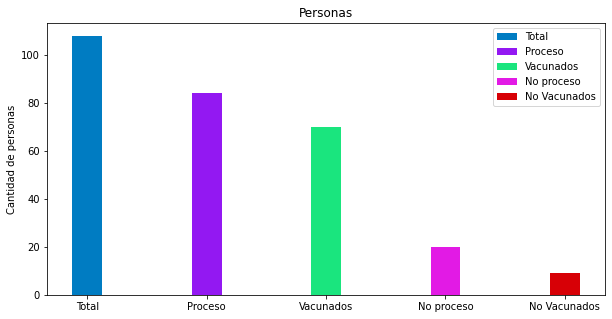

In [66]:

x = [1,2,3,4,5]

tags = ['Total','Proceso', 'Vacunados','No proceso', 'No Vacunados']

fig, ax = plt.subplots(figsize=(10,5))
bar1 = ax.bar(x[0], len(estado_personas), 0.25, label='Total', color="#007CC2")
bar2 = ax.bar(x[1], proceso, 0.25, label='Proceso', color="#9318F2")
bar3= ax.bar(x[2], vacunados, 0.25, label='Vacunados', color="#1AE57E")
bar4 = ax.bar(x[3], no_proceso, 0.25, label='No proceso', color='#E21AE5')
bar5= ax.bar(x[4], no_atendidos, 0.25, label='No Vacunados', color="#D70006")


ax.set_ylabel('Cantidad de personas')
ax.set_title('Personas')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")

plt.show()